In [24]:
import yt
import numpy as np
import scipy
import scipy.optimize
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

In [25]:
style_file = '/home/monal/setup/general.mplstyle'
plt.style.use(style_file)

In [26]:
rc('text', usetex = False)
rc('font', **{'family' : "sans-serif"})
# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}

## Exact Riemann problem solution

In [21]:
def sound_speed(gamma, pressure, density, dustFrac=0.):
    """
    Calculate sound speed, scaled by the dust fraction according to:
        
        .. math::
            \widetilde{c}_s = c_s \sqrt{1 - \epsilon}
    
    Where :math:`\epsilon` is the dustFrac
    """
    scale = np.sqrt(1 - dustFrac)
    return np.sqrt(gamma * pressure/ density) * scale

def shock_tube_function(p4, p1, p5, rho1, rho5, gamma, dustFrac=0.):
    """
    Shock tube equation
    """
    z = (p4 / p5 - 1.)
    c1 = sound_speed(gamma, p1, rho1, dustFrac)
    c5 = sound_speed(gamma, p5, rho5, dustFrac)
    
    gm1 = gamma - 1.
    gp1 = gamma + 1.
    g2 = 2. * gamma

    fact = gm1 / g2 * (c5 / c1) * z / np.sqrt(1. + gp1 / g2 * z)
    fact = (1. - fact) ** (g2 / gm1)

    return p1 * fact - p4


def calculate_regions(pl, ul, rhol, pr, ur, rhor, gamma=1.4, dustFrac=0.):
    """
    Compute regions
    :rtype : tuple
    :return: returns p, rho and u for regions 1,3,4,5 as well as the shock speed
    """
    # if pl > pr...
    rho1 = rhol
    p1 = pl
    u1 = ul
    rho5 = rhor
    p5 = pr
    u5 = ur

    # unless...
    if pl < pr:
        rho1 = rhor
        p1 = pr
        u1 = ur
        rho5 = rhol
        p5 = pl
        u5 = ul

    # solve for post-shock pressure
    p4 = scipy.optimize.fsolve(shock_tube_function, p1, (p1, p5, rho1, rho5, gamma))[0]

    # compute post-shock density and velocity
    z = (p4 / p5 - 1.)
    c5 = sound_speed(gamma, p5, rho5, dustFrac)


    gm1 = gamma - 1.
    gp1 = gamma + 1.
    gmfac1 = 0.5 * gm1 / gamma
    gmfac2 = 0.5 * gp1 / gamma

    fact = np.sqrt(1. + gmfac2 * z)

    u4 = c5 * z / (gamma * fact)
    rho4 = rho5 * (1. + gmfac2 * z) / (1. + gmfac1 * z)

    # shock speed
    w = c5 * fact
    
    print("c5 = ",c5)
    print("us = ",w)
    print("Ms = ",w/c5)

    # compute values at foot of rarefaction
    p3 = p4
    u3 = u4
    rho3 = rho1 * (p3 / p1)**(1. / gamma)
    return (p1, rho1, u1), (p3, rho3, u3), (p4, rho4, u4), (p5, rho5, u5), w


def calc_positions(pl, pr, region1, region3, w, xi, t, gamma, dustFrac=0.):
    """
    :return: tuple of positions in the following order ->
            Head of Rarefaction: xhd,  Foot of Rarefaction: xft,
            Contact Discontinuity: xcd, Shock: xsh
    """
    p1, rho1 = region1[:2]  # don't need velocity
    p3, rho3, u3 = region3
    c1 = sound_speed(gamma, p1, rho1, dustFrac)
    c3 = sound_speed(gamma, p3, rho3, dustFrac)
    
    if pl > pr:
        xsh = xi + w * t
        xcd = xi + u3 * t
        xft = xi + (u3 - c3) * t
        xhd = xi - c1 * t
    else:
        # pr > pl
        xsh = xi - w * t
        xcd = xi - u3 * t
        xft = xi - (u3 - c3) * t
        xhd = xi + c1 * t

    return xhd, xft, xcd, xsh


def region_states(pl, pr, region1, region3, region4, region5):
    """
    :return: dictionary (region no.: p, rho, u), except for rarefaction region
    where the value is a string, obviously
    """
    if pl > pr:
        return {'Region 1': region1,
                'Region 2': 'RAREFACTION',
                'Region 3': region3,
                'Region 4': region4,
                'Region 5': region5}
    else:
        return {'Region 1': region5,
                'Region 2': region4,
                'Region 3': region3,
                'Region 4': 'RAREFACTION',
                'Region 5': region1}


def create_arrays(pl, pr, xl, xr, positions, state1, state3, state4, state5, 
                  npts, gamma, t, xi, dustFrac=0.):
    """
    :return: tuple of x, p, rho and u values across the domain of interest
    """
    xhd, xft, xcd, xsh = positions
    p1, rho1, u1 = state1
    p3, rho3, u3 = state3
    p4, rho4, u4 = state4
    p5, rho5, u5 = state5
    gm1 = gamma - 1.
    gp1 = gamma + 1.
    
    x_arr = np.linspace(xl, xr, npts)
    rho = np.zeros(npts, dtype=float)
    p = np.zeros(npts, dtype=float)
    u = np.zeros(npts, dtype=float)
    c1 = sound_speed(gamma, p1, rho1, dustFrac)
    if pl > pr:
        for i, x in enumerate(x_arr):
            if x < xhd:
                rho[i] = rho1
                p[i] = p1
                u[i] = u1
            elif x < xft:
                u[i] = 2. / gp1 * (c1 + (x - xi) / t)
                fact = 1. - 0.5 * gm1 * u[i] / c1
                rho[i] = rho1 * fact ** (2. / gm1)
                p[i] = p1 * fact ** (2. * gamma / gm1)
            elif x < xcd:
                rho[i] = rho3
                p[i] = p3
                u[i] = u3
            elif x < xsh:
                rho[i] = rho4
                p[i] = p4
                u[i] = u4
            else:
                rho[i] = rho5
                p[i] = p5
                u[i] = u5
    else:
        for i, x in enumerate(x_arr):
            if x < xsh:
                rho[i] = rho5
                p[i] = p5
                u[i] = -u1
            elif x < xcd:
                rho[i] = rho4
                p[i] = p4
                u[i] = -u4
            elif x < xft:
                rho[i] = rho3
                p[i] = p3
                u[i] = -u3
            elif x < xhd:
                u[i] = -2. / gp1 * (c1 + (xi - x) / t)
                fact = 1. + 0.5 * gm1 * u[i] / c1
                rho[i] = rho1 * fact ** (2. / gm1)
                p[i] = p1 * fact ** (2. * gamma / gm1)
            else:
                rho[i] = rho1
                p[i] = p1
                u[i] = -u1

    return x_arr, p, rho, u


def solve(left_state, right_state, geometry, t, gamma=1.4, npts=500, 
          dustFrac=0.):
    """
    Solves the Sod shock tube problem (i.e. riemann problem) of discontinuity 
    across an interface.
    
    Parameters
    ----------
    left_state, right_state: tuple
        A tuple of the state (pressure, density, velocity) on each side of the
        shocktube barrier for the ICs.  In the case of a dusty-gas, the density
        should be the gas density.
    geometry: tuple
        A tuple of positions for (left boundary, right boundary, barrier)
    t: float
        Time to calculate the solution at
    gamma: float
        Adiabatic index for the gas.
    npts: int
        number of points for array of pressure, density and velocity
    dustFrac: float
        Uniform fraction for the gas, between 0 and 1.
    
    Returns
    -------
    positions: dict
        Locations of the important places (rarefaction wave, shock, etc...)
    regions: dict
        constant pressure, density and velocity states in distinct regions
    values: dict
        Arrays of pressure, density, and velocity as a function of position.
        The density ('rho') is the gas density, which may differ from the 
        total density in a dusty-gas.
        Also calculates the specific internal energy
    """

    pl, rhol, ul = left_state
    pr, rhor, ur = right_state
    xl, xr, xi = geometry

    # basic checking
    if xl >= xr:
        print('xl has to be less than xr!')
        exit()
    if xi >= xr or xi <= xl:
        print('xi has in between xl and xr!')
        exit()

    # calculate regions
    region1, region3, region4, region5, w = \
        calculate_regions(pl, ul, rhol, pr, ur, rhor, gamma, dustFrac)

    regions = region_states(pl, pr, region1, region3, region4, region5)

    # calculate positions
    x_positions = calc_positions(pl, pr, region1, region3, w, xi, t, gamma,
                                 dustFrac)

    pos_description = ('Head of Rarefaction', 'Foot of Rarefaction',
                       'Contact Discontinuity', 'Shock')
    positions = dict(zip(pos_description, x_positions))

    # create arrays
    x, p, rho, u = create_arrays(pl, pr, xl, xr, x_positions,
                                 region1, region3, region4, region5,
                                 npts, gamma, t, xi, dustFrac)

    energy = p/(rho * (gamma - 1.0))
    rho_total = rho/(1.0 - dustFrac)
    val_dict = {'x':x, 'p':p, 'rho':rho, 'u':u, 'energy':energy, 
                'rho_total':rho_total}

    return positions, regions, val_dict

c5 =  1.058300524425836
us =  1.7521557320301784
Ms =  1.655631544717208
Positions:
Head of Rarefaction : 0.26335680867601535
Foot of Rarefaction : 0.4859454374877634
Contact Discontinuity : 0.6854905240097902
Shock      : 0.8504311464060357
Regions:
Region 1   : (1, 1, 0)
Region 2   : RAREFACTION
Region 3   : (0.303130178050647, 0.4263194281784954, 0.9274526200489505)
Region 4   : (0.303130178050647, 0.2655737117053072, 0.9274526200489505)
Region 5   : (0.1, 0.125, 0.0)


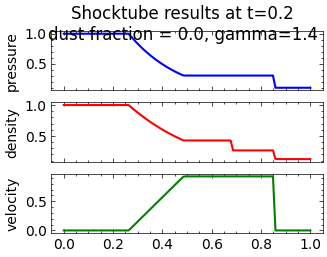

In [22]:
#exact solution
gamma = 1.4
dustFrac = 0.0
npts = 100
#test 3
# t = 0.012
# left_state = (1000,1,0)
# right_state = (1, 1, 0.)

#test 1
t = 0.2
left_state = (1,1,0)
right_state = (0.1, 0.125, 0.)

# left_state and right_state set pressure, density and u (velocity)
# geometry sets left boundary on 0., right boundary on 1 and initial
# position of the shock xi on 0.5
# t is the time evolution for which positions and states in tube should be 
# calculated
# gamma denotes specific heat
# note that gamma and npts are default parameters (1.4 and 500) in solve 
# function
positions, regions, values = solve(left_state=left_state, \
    right_state=right_state, geometry=(0., 1., 0.5), t=t, 
    gamma=gamma, npts=npts, dustFrac=dustFrac)
# Printing positions
print('Positions:')
for desc, vals in positions.items():
    print('{0:10} : {1}'.format(desc, vals))

# Printing p, rho and u for regions
print('Regions:')
for region, vals in sorted(regions.items()):
    print('{0:10} : {1}'.format(region, vals))

# Finally, let's plot the solutions
f, axarr = plt.subplots(len(values)-3, sharex=True)

axarr[0].plot(values['x'], values['p'], linewidth=1.5, color='b')
axarr[0].set_ylabel('pressure')
# axarr[0].set_ylim(0, 1.1)

axarr[1].plot(values['x'], values['rho'], linewidth=1.5, color='r')
axarr[1].set_ylabel('density')
# axarr[1].set_ylim(0, 1.1)

axarr[2].plot(values['x'], values['u'], linewidth=1.5, color='g')
axarr[2].set_ylabel('velocity')

plt.suptitle('Shocktube results at t={0}\ndust fraction = {1}, gamma={2}'\
             .format(t, dustFrac, gamma))
plt.show()

## Comparison of SSPRK schemes against exact Riemann problem solution

#### What should we expect?

#### From AMR solver

In [109]:
files = ['./m2/plot/plt00043','./m3/plot/plt00022','./m4/plot/plt00017','./m5/plot/plt00014']
data = []
ndata = len(files)
for i in range(0,ndata):
    data.append(yt.load(files[i]))


yt : [INFO     ] 2023-06-19 15:30:46,380 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-06-19 15:30:46,381 Parameters: domain_dimensions         = [100  32  32]
yt : [INFO     ] 2023-06-19 15:30:46,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-19 15:30:46,383 Parameters: domain_right_edge         = [10. 10. 10.]
yt : [INFO     ] 2023-06-19 15:30:46,414 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-06-19 15:30:46,415 Parameters: domain_dimensions         = [100  32  32]
yt : [INFO     ] 2023-06-19 15:30:46,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-19 15:30:46,417 Parameters: domain_right_edge         = [10. 10. 10.]
yt : [INFO     ] 2023-06-19 15:30:46,450 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-06-19 15:30:46,451 Parameters: domain_dimensions         = [100  32  32]
yt : [INFO     ] 2023-06-19 15:30:46,451 Parameters: domain_left_edge          = [0. 0

/tmp/ipykernel_4034114/1366560184.py:45: RuntimeWarning: invalid value encountered in divide
  '\n Rel error/Rel cost =',np.round(rel_error/rel_cost,2),



 Stages         = [2, 3, 4, 5] 
 CFL max        = [1. 2. 3. 4.] 
 CFL max stable = [1.   2.   2.58 3.24] 
 L2 error       = [1.15 1.22 1.18 1.17] 
 Run time(s)    = [4.36 3.27 3.37 3.57] 

 Rel error          = [0.   0.06 0.02 0.01] 
 Rel cost           = [ 0.   -0.25 -0.23 -0.18] 
 Rel error/Rel cost = [  nan -0.23 -0.1  -0.08]


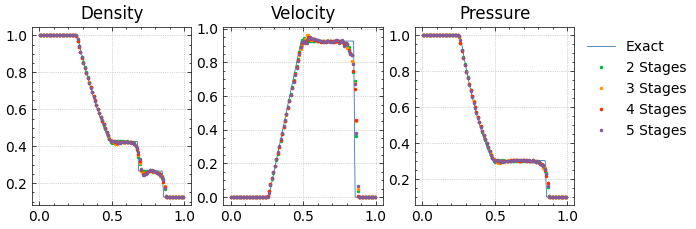

In [161]:
# constants
lx = 10
xcut = 0
ycut = 0

amr_fields = ['density','x_velocity','pressure']
exact_rs_fields=['rho','u','p']
plot_labels = ['Density','Velocity','Pressure']
fig,axes = plt.subplots(1,3)
fig.set_size_inches(7*np.array([1.0,0.33]))
nplots = len(amr_fields)

error = np.zeros(ndata)
for i in range(0,nplots):
    for j in range(0,ndata):
        ray = data[j].ortho_ray('x', coords=(0.125, xcut, ycut))  
        srt = np.argsort(ray['x'])
        y_exact = np.array(values[exact_rs_fields[i]])
        y_cfd   = np.array(ray[amr_fields[i]][srt])
        if(j==0):
            axes[i].plot(values['x'], y_exact, label='Exact',linewidth=0.5)
            axes[i].set_title(plot_labels[i])
            axes[i].grid(True,linestyle='dotted') 
        axes[i].plot(ray['x'][srt]/lx,y_cfd,label=str(2+j) + ' Stages',
                     linewidth=0.0, marker='.', markersize=3.0)
        error[j] += np.linalg.norm(y_cfd- y_exact,2)

axes[-1].legend(bbox_to_anchor=(1, 1))



cost = np.array([4.3631,3.2679,3.369,3.566]) # runtime in seconds
cfl_max_stable = np.array([1.0, 2.0, 2.58, 3.24])

rel_error = (error-error[0])/error[0]
rel_cost  = (cost-cost[0])/cost[0]
print('\n Stages         =',list(range(2,6)),
      '\n CFL max        =',np.array(range(1,5),dtype=float),
      '\n CFL max stable =',cfl_max_stable,
      '\n L2 error       =',np.round(error,2),
      '\n Run time(s)    =',np.round(cost,2),
      
      '\n\n Rel error          =',np.round(rel_error,2),
      '\n Rel cost           =',np.round(rel_cost,2),
      '\n Rel error/Rel cost =',np.round(rel_error/rel_cost,2),
     )

# plt.savefig(folder_latex + 'sods_test_varying_levels',dpi=600,bbox_inches='tight')

- Only stages 2 and 3 are stable at max theoretical CFL. The other stages, have oscillatory solutions around the discontiunity in time and space immediately after initialisation (not shown here).
- Stage 2 method is worst in terms of error and cost. Stage 3 is fastest but has higher error than higher stages.
- Increasing the number of stages is brings the error to cost ratio (relative to 2 stage SSPRK2) towards zero.

Therefore, 2 stage SSPRK should not be used (unless stability becomes an issue) and higher number of stages should be preferred.